In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [51]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

data_all=hf.add_MSI_noise(data_all,channel_labels)

Noise standard deviation for Cloud_B02: 0.00335001428051948
Noise standard deviation for Cloud_B03: 0.002912530185416667
Noise standard deviation for Cloud_B04: 0.004058081082042254
Noise standard deviation for Cloud_B05: 0.0046524891611111115
Noise standard deviation for Cloud_B06: 0.007455351321348316
Noise standard deviation for Cloud_B07: 0.008871707484285717
Noise standard deviation for Cloud_B08: 0.04489677938000001
Noise standard deviation for Cloud_B09: 0.005688141120114942
Noise standard deviation for Cloud_B10: 0.003909328971491229
Noise standard deviation for Cloud_B11: 0.0014014724139999996
Noise standard deviation for Cloud_B12: 0.005030040539999999
Noise standard deviation for Cloud_B13: 0.004041267081999999


In [52]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

X_truth=df_truth[X_labels]

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

In [53]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

In [54]:
quantiles=np.array([0.1,0.5,0.9])
batch_size=100
nepochs=10

model=QuantileNetwork(quantiles=quantiles)
model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs)

Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 347.30it/s]


Training loss [0.8456738] Validation loss [0.6395272]
----New best validation loss---- [0.6395272]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:03<00:00, 457.95it/s]


Training loss [0.59654695] Validation loss [0.57396394]
----New best validation loss---- [0.57396394]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 396.89it/s]

Training loss [0.55694133] Validation loss [0.54344064]
----New best validation loss---- [0.54344064]
Epoch 4



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 448.77it/s]

Training loss [0.5329366] Validation loss [0.52380335]
----New best validation loss---- [0.52380335]
Epoch 5



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 435.07it/s]

Training loss [0.5156535] Validation loss [0.5122669]
----New best validation loss---- [0.5122669]
Epoch 6



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 424.20it/s]

Training loss [0.50481737] Validation loss [0.5161043]
Epoch 7



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 450.34it/s]


Training loss [0.49471426] Validation loss [0.49048644]
----New best validation loss---- [0.49048644]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 379.67it/s]


Training loss [0.48767546] Validation loss [0.4875494]
----New best validation loss---- [0.4875494]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 407.63it/s]


Training loss [0.48111492] Validation loss [0.4881064]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 395.95it/s]

Training loss [0.4757301] Validation loss [0.47464436]
----New best validation loss---- [0.47464436]
Best model out of total max epochs found at epoch 10


In [55]:
preds = model.predict(X_test.to_numpy())

In [56]:
## MSE ##
mean_squared_error(y_test.to_numpy(),preds[:,:,1])

0.005750888593147246

In [57]:
## PSNR ##
QuantileNetwork.PSNR(y_test,preds[:,:,1])

27.120802353234325

In [58]:
## Outrate ##
QuantileNetwork.calc_outrate(y_test.to_numpy(),preds)

0.21895

## Visualise

In [59]:
X_test

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,Cloud_B11,Cloud_B12,Cloud_B13,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle
43160,0.155742,0.075139,-0.170042,0.000421,-0.387747,-1.165321,-1.271482,-1.222638,-0.048526,-0.267511,-1.010814,-0.938678,0.037327,0.533748,-1.530063
9813,0.473440,0.375515,0.248508,0.287647,0.143759,-0.241226,-0.421920,-0.324332,-0.017606,-0.417874,-0.994835,-0.877778,-0.357736,0.632131,1.695460
37684,-1.135652,-1.068956,-1.011228,-1.131144,-1.017791,0.750211,0.928491,1.114626,-1.179593,-0.642596,1.114913,1.064426,1.345423,0.993024,-0.839502
24246,0.527790,0.496211,0.379827,0.726194,0.508507,-0.303016,-0.263858,-0.195492,0.802932,2.572800,-0.842604,-0.666262,-0.988009,0.443440,-0.258753
15011,0.409438,0.427315,0.496006,0.313805,0.633212,0.383216,0.153650,0.196747,0.753757,1.668816,-0.765117,-0.536364,-1.228039,-1.531885,-0.920173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44683,-0.614643,-0.577452,-0.620392,-0.695929,-0.625460,0.082537,-0.018168,0.134186,-0.960420,-0.266420,0.781996,0.493907,-1.067481,-0.751662,-1.563850
40878,0.234753,0.234908,0.194977,0.094113,0.150352,0.387228,0.173691,0.257541,-0.077532,-0.064036,0.236809,-0.152068,-0.572624,-1.596031,0.439092
40485,0.066344,-0.001230,-0.116131,-0.216721,-0.378794,-0.241760,-0.544341,-0.290209,-1.289885,-0.658971,0.196177,0.037753,-0.101038,0.238061,-1.714878
41277,0.120369,-0.000514,-0.161013,-0.068776,-0.379179,-0.447098,-0.443049,-0.455189,-0.266367,-0.471259,-0.939478,-0.872771,-0.533667,1.025504,-0.513537


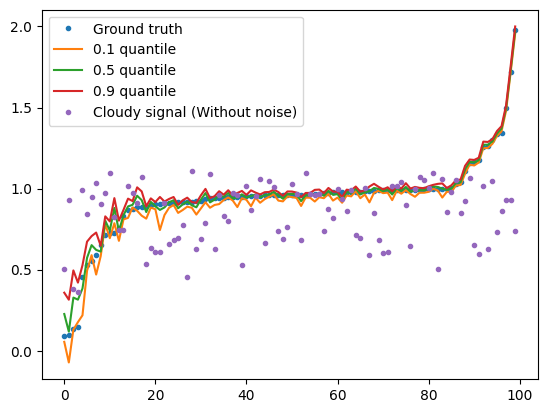

In [61]:
samples=100
channel=5

#Get ground truth y
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
sort_ind=np.argsort(y_plot)
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

# Get cloudy signal
cloudy=X_test_truth.to_numpy()[:,channel]
cloudy=cloudy[0:samples]
cloudy_sort=cloudy[sort_ind]


plt.plot(y_plot_sort,'.')
plt.plot(y_pred_sort)
plt.plot(cloudy_sort,'.')
plt.legend(['Ground truth','0.1 quantile', '0.5 quantile','0.9 quantile','Cloudy signal (Without noise)'])
plt.show()


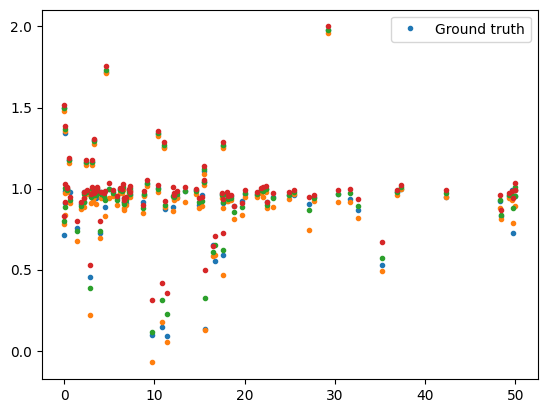

In [74]:
df_test=df.iloc[y_test.index]

#Get cot values
cot_column=df_test['COT'].to_numpy()
cot_column=cot_column[0:samples]
sort_ind=np.argsort(cot_column)
cot_column_sort=cot_column[sort_ind]

#Get ground truth
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

plt.plot(cot_column_sort,y_plot_sort,'.')
plt.plot(cot_column_sort,y_pred_sort,'.')
plt.legend(['Ground truth'])